#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

In [3]:
from sources import load_dataset, parse_config, setup_model
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase, OrthoKernelBase
from steered_cnn.models import SteeredHemelingNet, HemelingNet
from src.trainer import BinaryClassifierNet

## Orientation Detection

#### Generating a Directional Map

In [4]:
base = SteerableKernelBase.from_steerable(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = (x+y)/4
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}
W = base.approximate_weights(K, info)

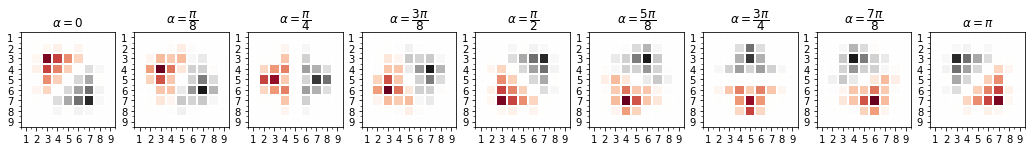

In [10]:
I = torch.zeros((1,1,9,9))
I[:,:,4,4] = 1
N = 8
fig, axs = plt.subplots(1,N+1)
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
rotations = []
rotations_label = []
for i in range(N+1):
    r = base.conv2d(I,W, alpha=alphas[i])[0,0]
    plot_filter(r, plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')
    rotations += [r]
    rotations_label += [repr_pi_fraction(i,N)]
rotations = torch.stack(rotations)

### Vectorial Attention 

In [6]:
ortho_base = OrthoKernelBase.from_steerable(4)


In [14]:
w = torch.abs(ortho_base.create_weights(1,1))
v = ortho_base.ortho_conv2d(rotations[:,None], w, padding='true').squeeze()
alpha = torch.atan2(v[1], v[0])
rho = torch.linalg.norm(v, dim=0)

print('alpha:', (alpha-alpha[0])%(2*np.pi))
print('alpha diff:', ((alpha-alpha[0])%(2*np.pi))-torch.Tensor(alphas))
print('rho:', rho)

alpha: tensor([0.0000, 0.3684, 0.7518, 1.1481, 1.5708, 1.9392, 2.3226, 2.7189, 3.1416])
alpha diff: tensor([ 0.0000e+00, -2.4292e-02, -3.3603e-02, -2.9982e-02,  1.1921e-07,
        -2.4292e-02, -3.3603e-02, -2.9982e-02,  0.0000e+00])
rho: tensor([1.7221, 1.7065, 1.7101, 1.7077, 1.7221, 1.7065, 1.7101, 1.7077, 1.7221])


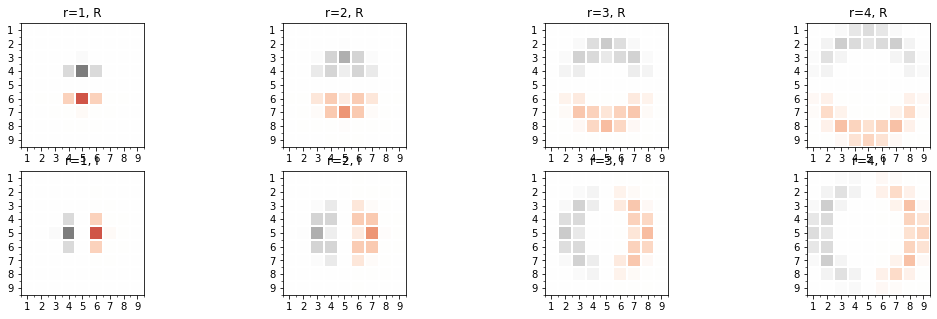

In [9]:
fig, axs = plt.subplots(2,4)
for i in range(8):
    plot_filter(ortho_base.base[i], plot=axs[i//4][i%4], vmax=1)
    axs[i//4][i%4].set_title(f'r={i%4+1}, {"I" if i>=4 else "R"}')